In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Read and preprocess raw performance data

In [2]:
# Aggregate all performance measurements (of all individual requests) from all experimental cases
agg_df = pd.DataFrame()
for results_file_name in os.listdir("performance_characterization_data_raw"):
    df = pd.read_csv("performance_characterization_data_raw/%s" % (results_file_name))
    df = df[df['status']==200]
    df['gpu'] = [str(n_gpus) + ' x ' + gpu_type for n_gpus, gpu_type in zip(df['n_gpus'], df['gpu_type'])]   
    agg_df = pd.concat([agg_df, df])
agg_df.to_csv("performance_characterization_data_full.csv")

# Process the aggregate dataset to only include averaged performance metrics from each experimental case
final_df = pd.DataFrame()
exp_case_cols = ["model", "gpu", "num_users"]

# Throughput of the experimental case: total number of output tokens generated across all requests
# divided by the duration of the experiment, expressed in [tokens/s]
final_df["throughput"] = (
    agg_df.groupby(exp_case_cols)["n_output_tokens"].sum()
    / agg_df.groupby(exp_case_cols)["experiment_duration_s"].first()
)

# Keep details of all individual requests: latencies per token and numbers of input/output tokens
final_df["latencies_all"] = agg_df.groupby(exp_case_cols)["latency_ms_per_token"].apply(list)
final_df["n_input_tokens_list"] = agg_df.groupby(exp_case_cols)["n_input_tokens"].apply(list)
final_df["n_output_tokens_list"] = agg_df.groupby(exp_case_cols)["n_output_tokens"].apply(list)
final_df = final_df.reset_index()

# Store all individual latency metrics collected across all requests: time to first token (TTFT), 
# inter-token latency (ITL), and normalized TTFT (nTTFT) = TTFT / n_input_tokens
final_df["ttft_list"] = [[eval(el)[1] for el in l] for l in final_df["latencies_all"]]
final_df["nttft_list"] = [[eval(el)[1]/in_tok for el, in_tok in zip(l, t)] for l, t in zip(final_df["latencies_all"], final_df["n_input_tokens_list"])]
final_df["itl_list"] = [[v for el in l for v in eval(el)[2:]] for l in final_df["latencies_all"]]

# Average latency metrics per experimental case to a single value
final_df["median_ttft"] = final_df["ttft_list"].apply(lambda l: np.nanmedian(l))
final_df["median_nttft"] = final_df["nttft_list"].apply(lambda l: np.nanmedian(l))
final_df["median_itl"] = final_df["itl_list"].apply(lambda l: np.nanmedian(l))

# Cost of the respective GPU profile - hourly price read from AWS on-demand GPU instance pricing tables
prices = pd.read_csv("prices.csv")
final_df['cost'] = final_df["gpu"].apply(lambda g: prices[prices['GPU'] == g]['price'].iloc(0)[0])

# Throughput per cost: throughput divided by the cost of the respective GPU profile
# Hourly price is converted to price per second so the final unit of throughput/$
# makes more sense: [tokens/s/$]
final_df["throughput/$"] = final_df['throughput'] / (final_df['cost']/3600)

# Save and display final aggregate dataset
final_df.to_csv("performance_characterization_data.csv")
final_df

,model,gpu,num_users,throughput,latencies_all,n_input_tokens_list,n_output_tokens_list,ttft_list,nttft_list,itl_list,median_ttft,median_nttft,median_itl,cost,throughput/$
0,EleutherAI/gpt-neox-20b,1 x H100,1,50.166667,"[[8, 164, 19, 19, 18, 19, 18, 19, 18, 19, 18, ...","[39.0, 67.0, 86.0, 83.0, 364.0, 140.0, 563.0, ...","[55.0, 39.0, 20.0, 20.0, 25.0, 36.0, 11.0, 29....","[164, 119, 116, 45, 63, 116, 82, 45, 45, 44, 4...","[4.205128205128205, 1.7761194029850746, 1.3488...","[19, 19, 18, 19, 18, 19, 18, 19, 18, 19, 19, 1...",44.0,0.529412,19.0,12.290,14694.873881
1,EleutherAI/gpt-neox-20b,1 x H100,2,88.400000,"[[5, 170, 22, 22, 22, 21, 22, 21, 22, 22, 21, ...","[39.0, 874.0, 67.0, 182.0, 83.0, 86.0, 364.0, ...","[55.0, 18.0, 18.0, 14.0, 20.0, 20.0, 25.0, 20....","[170, 170, 59, 62, 59, 58, 76, 59, 77, 98, 149...","[4.358974358974359, 0.1945080091533181, 0.8805...","[22, 22, 22, 21, 22, 21, 22, 22, 21, 22, 22, 2...",59.0,0.712644,20.0,12.290,25894.222945
2,EleutherAI/gpt-neox-20b,1 x H100,4,142.150000,"[[6, 142, 23, 24, 23, 24, 23, 23, 24, 23, 23, ...","[93.0, 39.0, 874.0, 85.0, 182.0, 18.0, 58.0, 5...","[20.0, 55.0, 18.0, 20.0, 14.0, 1.0, 20.0, 62.0...","[142, 138, 138, 142, 65, 41, 117, 61, 59, 60, ...","[1.5268817204301075, 3.5384615384615383, 0.157...","[23, 24, 23, 24, 23, 23, 24, 23, 23, 24, 23, 2...",82.0,1.226190,22.0,12.290,41638.730675
3,EleutherAI/gpt-neox-20b,1 x H100,8,220.375000,"[[9, 169, 24, 25, 100, 27, 26, 26, 26, 27, 24,...","[874.0, 13.0, 85.0, 39.0, 335.0, 83.0, 87.0, 1...","[18.0, 1.0, 20.0, 3.0, 16.0, 20.0, 20.0, 1.0, ...","[169, 135, 161, 169, 119, 173, 173, 110, 196, ...","[0.19336384439359267, 10.384615384615385, 1.89...","[24, 25, 100, 27, 26, 26, 26, 27, 24, 25, 53, ...",141.0,1.899541,25.0,12.290,64552.481692
4,EleutherAI/gpt-neox-20b,1 x H100,16,312.675000,"[[5, 293, 29, 30, 222, 34, 29, 29, 29, 28, 29,...","[874.0, 10.0, 13.0, 58.0, 83.0, 85.0, 90.0, 13...","[72.0, 1.0, 1.0, 5.0, 20.0, 20.0, 20.0, 1.0, 1...","[293, 260, 252, 269, 273, 289, 319, 239, 259, ...","[0.3352402745995423, 26.0, 19.384615384615383,...","[29, 30, 222, 34, 29, 29, 29, 28, 29, 147, 33,...",232.0,3.071358,31.0,12.290,91589.096827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,llama-7b,4 x T4,8,168.425000,"[[23, 386, 28, 25], [11, 398, 28, 25, 27, 185,...","[39.0, 93.0, 335.0, 87.0, 10.0, 13.0, 140.0, 3...","[3.0, 20.0, 16.0, 20.0, 1.0, 1.0, 6.0, 55.0, 2...","[386, 398, 164, 391, 390, 51, 216, 385, 577, 3...","[9.897435897435898, 4.279569892473118, 0.48955...","[28, 25, 28, 25, 27, 185, 27, 27, 27, 27, 29, ...",176.0,2.250000,28.0,3.912,154992.331288
524,llama-7b,4 x T4,16,231.333333,"[[31, 660], [21, 365, 40, 38, 33, 33, 33, 33, ...","[11.0, 563.0, 58.0, 85.0, 13.0, 874.0, 83.0, 3...","[1.0, 10.0, 5.0, 20.0, 1.0, 18.0, 20.0, 1.0, 2...","[660, 365, 668, 675, 673, 653, 663, 643, 658, ...","[60.0, 0.6483126110124334, 11.517241379310345,...","[40, 38, 33, 33, 33, 33, 33, 105, 41, 38, 31, ...",316.0,3.988366,37.0,3.912,212883.435583
525,llama-7b,4 x T4,32,279.108333,"[[78, 1272], [8, 1399, 44, 51, 44, 50, 371, 48...","[13.0, 140.0, 39.0, 83.0, 11.0, 84.0, 88.0, 18...","[1.0, 8.0, 3.0, 20.0, 1.0, 20.0, 20.0, 12.0, 1...","[1272, 1399, 1291, 1331, 1321, 1301, 1337, 132...","[97.84615384615384, 9.992857142857142, 33.1025...","[44, 51, 44, 50, 371, 48, 55, 44, 55, 44, 51, ...",534.0,7.313187,55.0,3.912,256848.159509
526,llama-7b,4 x T4,64,296.533333,"[[128, 2500, 78, 78, 75, 74, 72, 1024, 89, 88,...","[88.0, 85.0, 90.0, 10.0, 11.0, 85.0, 31.0, 88....","[20.0, 20.0, 31.0, 1.0, 1.0, 20.0, 1.0, 20.0, ...","[2500, 975, 2636, 2491, 2542, 2426, 2409, 2522...","[28.40909090909091, 11.470588235294118, 29.288...","[78, 78, 75, 74, 72, 1024, 89, 88, 71, 70, 87,...",1020.0,13.799603,88.0,3.912,272883.435583


# Generate performance plots for a selected LLM

In [3]:
df = pd.read_csv("performance_characterization_data.csv")
styles = {
    'H100': {'color': 'C1', 'marker': 's', 'size': 16, 'zorder': 5},
    'A100': {'color': 'C3', 'marker': 'o', 'size': 16, 'zorder': 5},
    'V100': {'color': 'C4', 'marker': 'D', 'size': 16, 'zorder': 5},
    'T4':   {'color': 'C0', 'marker': 'X', 'size': 20, 'zorder': 5},
    'A10':  {'color': 'C2', 'marker': '^', 'size': 20, 'zorder': 10},
}

GPU_TYPES_ORDER = ['H100', 'A100', 'V100', 'T4', 'A10',]
GPUS = sorted(df['gpu'].unique(), key=lambda x: x[0])
GPUS = sorted(GPUS, key=lambda x: list(styles.keys()).index(x.split(' ')[-1]))
linestyles = {
    1: ':',
    2: '--',
    4: '-',
}

plt.rcParams.update({'font.size': 35, "text.usetex": False, "font.family": "sans-serif"})

def plot_performance(model, latency_metric='median_itl', throughput_metric='throughput'):
    df_m = df[df['model'] == model]
    
    # Formatting settings
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=12, width=5)
    ax.tick_params(which='minor', length=7, width=3)
    
    # Draw curves for each GPU profile
    for gpu in GPUS:
        df_case = df_m[df_m['gpu'] == gpu]
        if len(df_case) == 0:
            continue
        
        if 'ttft' in latency_metric:
            plot_func = ax.loglog
        else:
            plot_func = ax.semilogx
            
        plot_func(df_case[throughput_metric], 
                  df_case[latency_metric], 
                  marker=styles[gpu[4:]]['marker'], 
                  markersize=styles[gpu[4:]]['size'],
                  label=gpu, 
                  linewidth=4, 
                  color=styles[gpu[4:]]['color'], 
                  linestyle=linestyles[int(gpu[0])], 
                  zorder=styles[gpu[4:]]['zorder']
                 )
         
    # Axis labels, legend, grid, etc.
    if '$' in throughput_metric:
        ax.set_xlabel("Throughput/\$ [tok/s/\$]", fontsize=40)
    else:
        ax.set_xlabel("Throughput [tok/s]", fontsize=40)
    if 'ttft' in latency_metric:
        ax.set_ylabel("TTFT [ms]", fontsize=40)
    else:
        ax.set_ylabel("ITL [ms/tok]", fontsize=40)
    if '$' not in throughput_metric:
        ax.set_xlim([15, 1000])
    ax.grid(True)
    ax.legend(fontsize=26, loc='upper left', ncol=1, handlelength=3)
    
    out_filename='performance_plot_%s_%s_%s.png' % (
        model.replace('/', '-'), 
        latency_metric.replace('median_', ''), 
        throughput_metric.replace('/$', '_per_cost')
    )
    plt.tight_layout()
    plt.savefig(out_filename)
    plt.show()

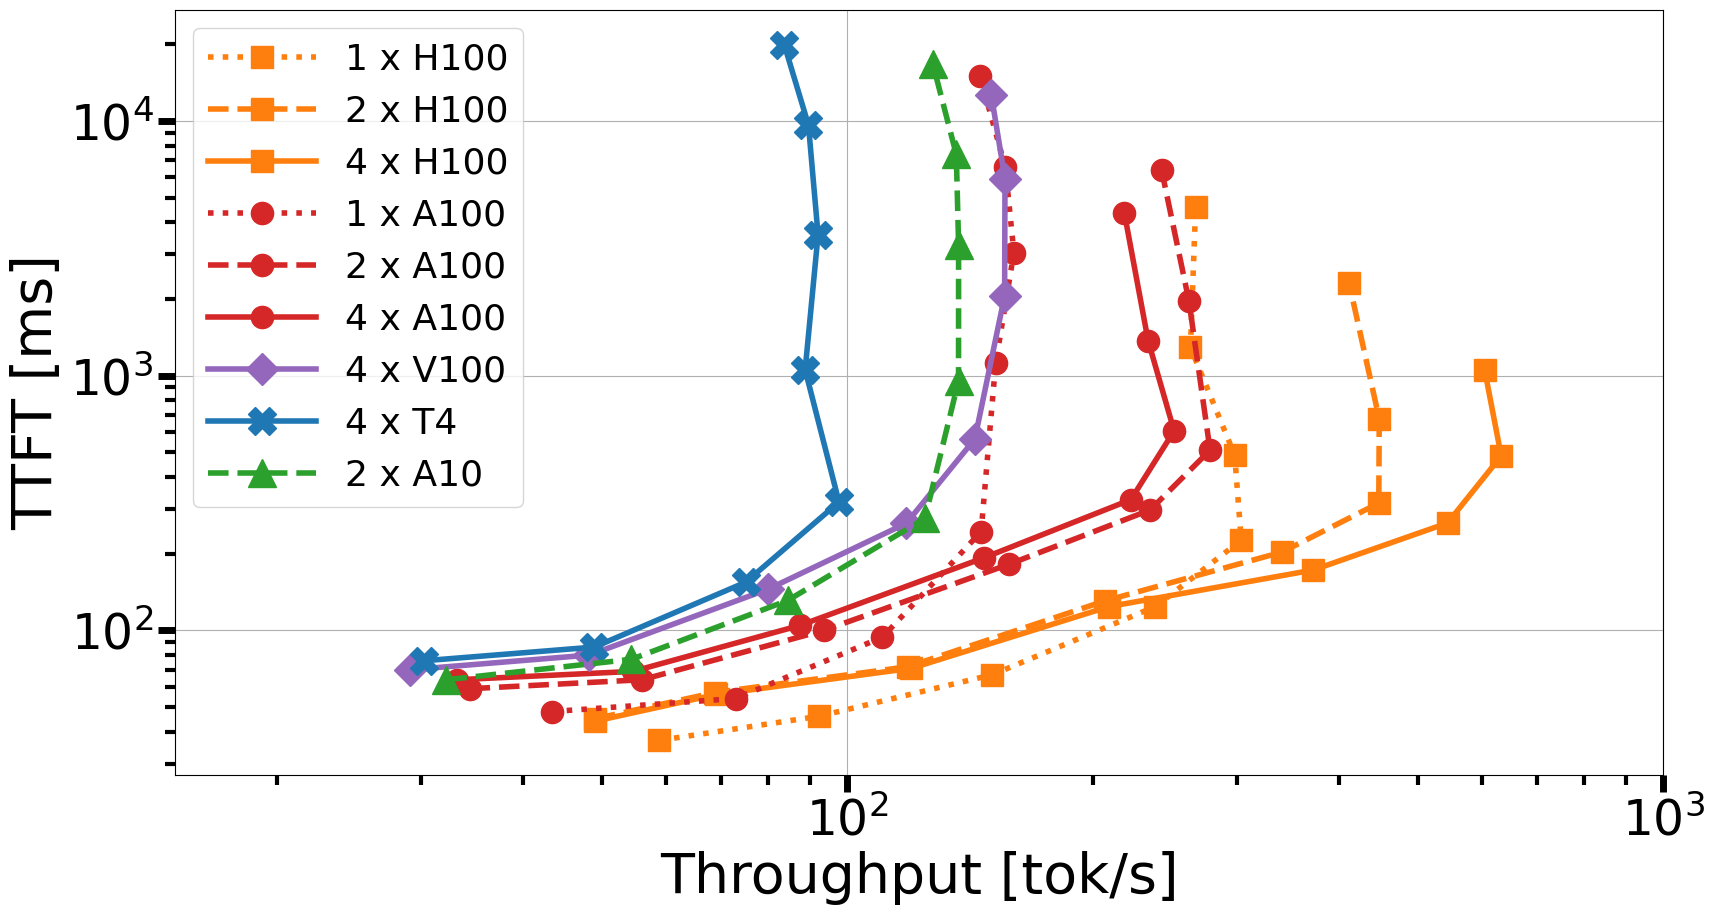

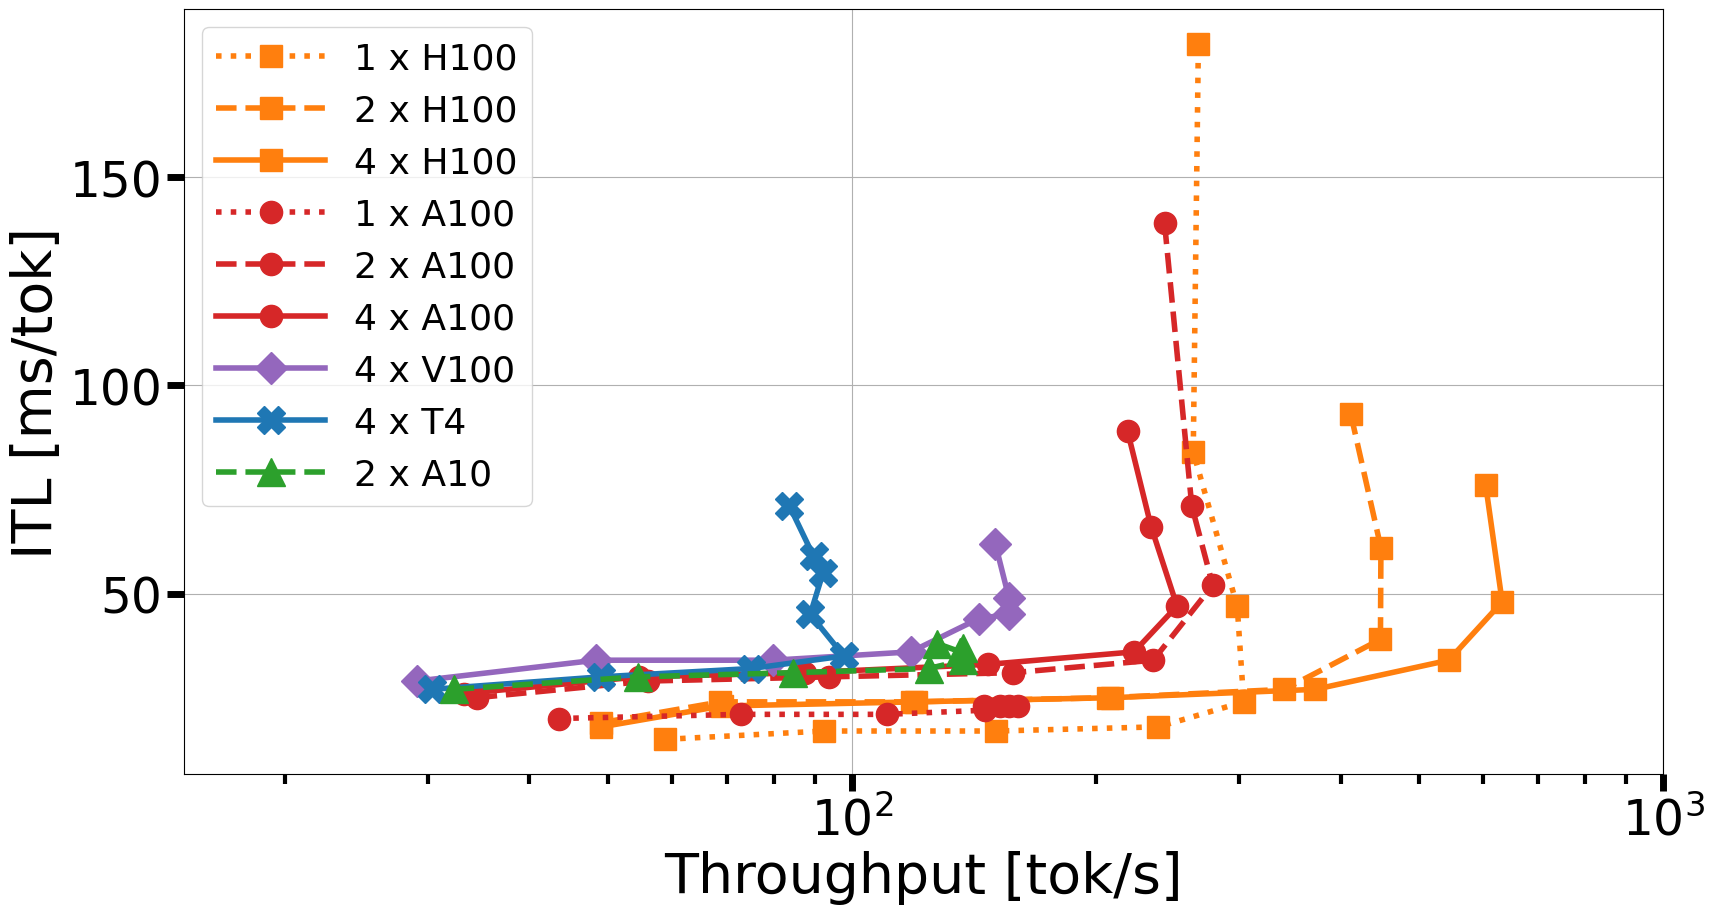

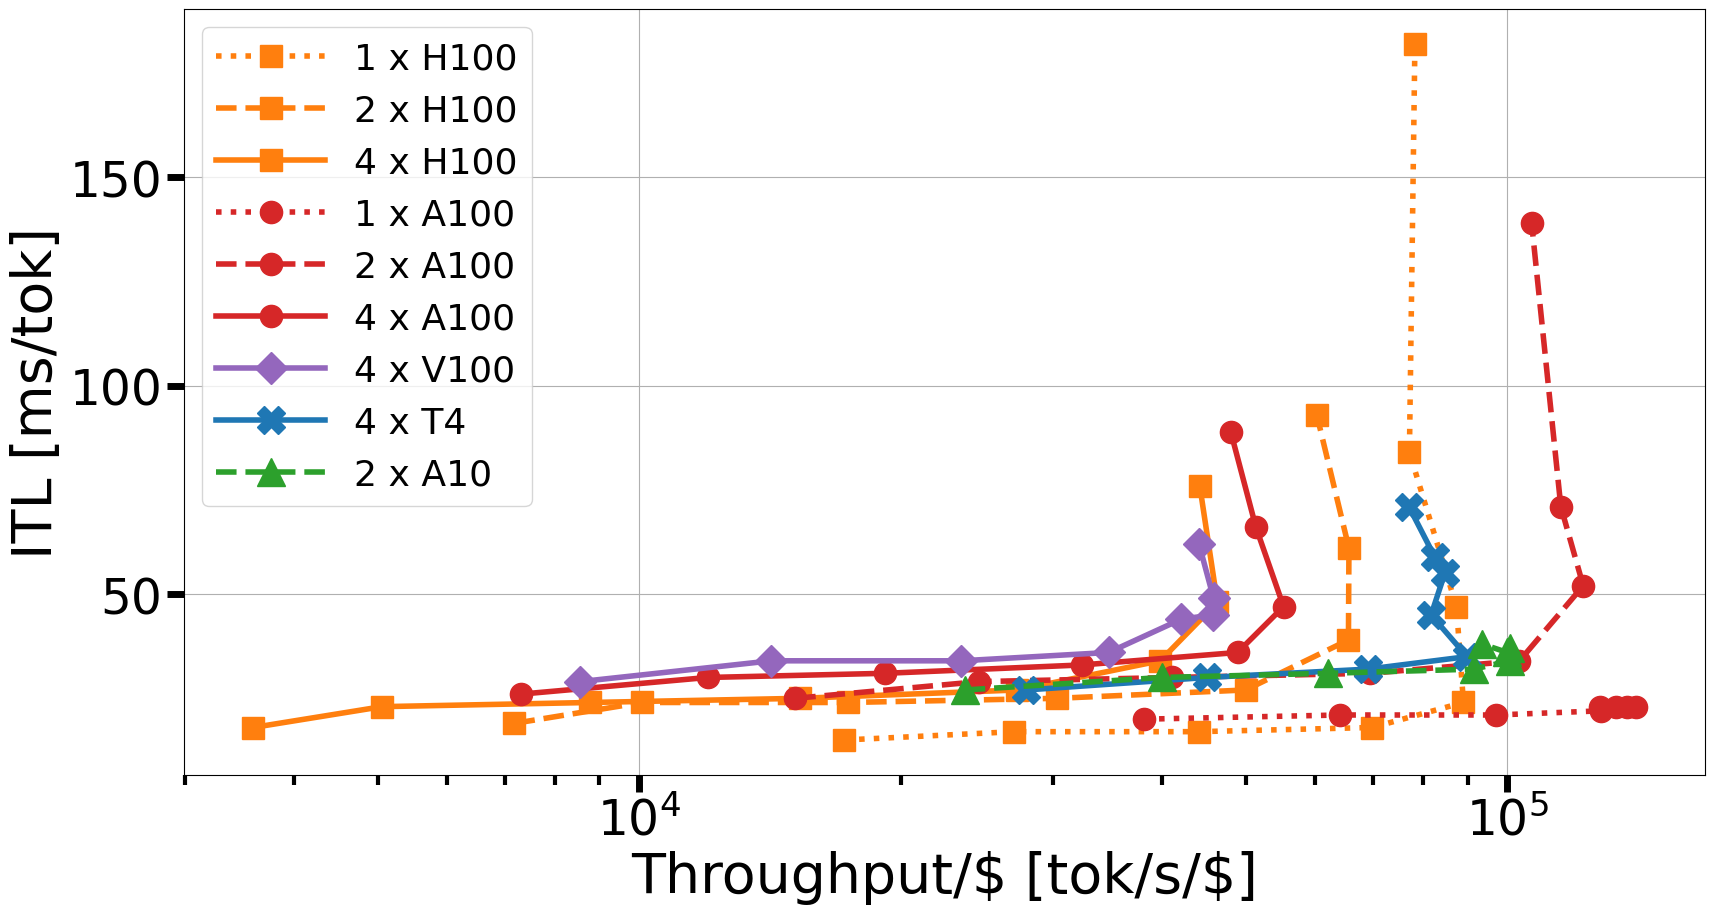

In [4]:
EXAMPLE_LLM = 'google/flan-t5-xxl'

plot_performance(model=EXAMPLE_LLM, 
                 latency_metric='median_ttft', 
                 throughput_metric='throughput')

plot_performance(model=EXAMPLE_LLM, 
                 latency_metric='median_itl', 
                 throughput_metric='throughput')

plot_performance(model=EXAMPLE_LLM, 
                 latency_metric='median_itl', 
                 throughput_metric='throughput/$')
